# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Data Preparation and Creating the Dataset Class model](#a)
2. [Base Model Training](#b)
3. [Training with Oversampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<a id=’a’></a>
## 1. Data Preparation and Creating the Dataset Class model

To recreate the labels and splits used in the study, you may copy and paste all the data (both train and test) provided in https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset to './data/Coronahack-Chest-XRay-Dataset/alldata' folder and then basically run the following cells.

In [15]:
# Import needed packages for the data preparation stage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

pd.options.mode.chained_assignment = None 

In [2]:
csv = 'data/Coronahack-Chest-XRay-Dataset/alldata/Chest_xray_Corona_Metadata.csv' # Assign the name of the csv file.
all_data = pd.read_csv(csv, encoding = 'ISO-8859-1', index_col=0) # Read the csv file.
all_data.head() # Inspect the raw data labels.

,X_ray_image_name,Label,Dataset_type,Label_Final,Label_2_Virus_category,Label_1_Virus_category,Final_split
0,IM-0128-0001.jpeg,Normal,TRAIN,Normal,NaN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,Normal,NaN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,Normal,NaN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,Normal,NaN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,Normal,NaN,NaN,NaN


In [3]:
train, test=train_test_split(all_data,test_size=0.1055,stratify=all_data['Label_Final'], random_state=101773) # Get a stratified train/test split of all dataset.
train, validation=train_test_split(train,test_size=0.1180,stratify=train['Label_Final'], random_state=101773) # Get a stratified train/test split of train dataset.

all_data.iloc[test.index,6]='TEST'
all_data.iloc[train.index,6]='TRAIN'
all_data.iloc[validation.index,6]='EVAL'

final_data = all_data[["X_ray_image_name", "Label_Final", "Final_split"]] # Get the needed columns for dataset class.
final_data.head()

,X_ray_image_name,Label_Final,Final_split
0,IM-0128-0001.jpeg,Normal,TRAIN
1,IM-0127-0001.jpeg,Normal,TRAIN
2,IM-0125-0001.jpeg,Normal,TRAIN
3,IM-0122-0001.jpeg,Normal,EVAL
4,IM-0119-0001.jpeg,Normal,TRAIN


<BarContainer object of 4 artists>

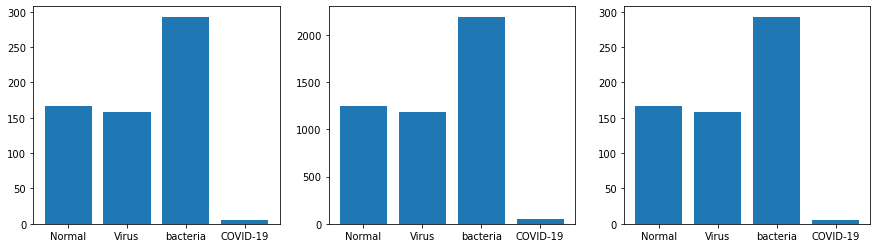

In [4]:
test_counter = Counter(final_data.loc[final_data['Final_split']=='TEST']['Label_Final']) # Get counts of classess in test split.
train_counter = Counter(final_data.loc[final_data['Final_split']=='TRAIN']['Label_Final']) # Get counts of classess in train split.
eval_counter = Counter(final_data.loc[final_data['Final_split']=='EVAL']['Label_Final']) # Get counts of classess in validation split.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4)) #Print histograms of class frequencies.
axes[0].bar(test_counter.keys(), test_counter.values())
axes[1].bar(train_counter.keys(), train_counter.values())
axes[2].bar(eval_counter.keys(), eval_counter.values())
#It is seen that all splits have very close distributions of classes.
#From now on, we will try to get the highest perfomance on this recreated test data.
#However, we see that the class imbalance is quite high in this problem. 
#So we have tried to design a multi-phase training technique to increase the model performance by decreasing its exposure to class imbalance.
#Train Set:Counter({'bacteria': 2191, 'Normal': 1244, 'Virus': 1181, 'COVID-19': 46})
plt.show()

In [5]:
#Here we create random first level undersampled data.
bacteria_rows=final_data.loc[final_data['Label_Final']=='bacteria'][final_data['Final_split']=='TRAIN']
bacteria_rows_sample=bacteria_rows.sample(n = 949,  random_state=101773) 
final_data["Label_Final2"] = final_data["Label_Final"]
final_data.loc[final_data['X_ray_image_name'].isin(bacteria_rows_sample['X_ray_image_name'].tolist()),"Label_Final2"]="None"

In [6]:
#Here we create random second level undersampled data.
bacteria_rows=final_data.loc[final_data['Label_Final']=='bacteria'][final_data['Final_split']=='TRAIN']
bacteria_rows_sample=bacteria_rows.sample(n = 1008,  random_state=101773) 
normal_rows=final_data.loc[final_data['Label_Final']=='Normal'][final_data['Final_split']=='TRAIN']
normal_rows_sample=normal_rows.sample(n = 57,  random_state=101773) 
final_data["Label_Final3"] = final_data["Label_Final"]
final_data.loc[final_data['X_ray_image_name'].isin(bacteria_rows_sample['X_ray_image_name'].tolist()),"Label_Final3"]="None"
final_data.loc[final_data['X_ray_image_name'].isin(normal_rows_sample['X_ray_image_name'].tolist()),"Label_Final3"]="None"

In [7]:
#Here we create random third level undersampled data.
bacteria_rows=final_data.loc[final_data['Label_Final']=='bacteria'][final_data['Final_split']=='TRAIN']
bacteria_rows_sample=bacteria_rows.sample(n = 2145,  random_state=1773) 
normal_rows=final_data.loc[final_data['Label_Final']=='Normal'][final_data['Final_split']=='TRAIN']
normal_rows_sample=normal_rows.sample(n = 1196,  random_state=1773) 
virus_rows=final_data.loc[final_data['Label_Final']=='Virus'][final_data['Final_split']=='TRAIN']
virus_rows_sample=virus_rows.sample(n = 1137,  random_state=1773) 
final_data["Label_Final4"] = final_data["Label_Final"]
final_data.loc[final_data['X_ray_image_name'].isin(bacteria_rows_sample['X_ray_image_name'].tolist()),"Label_Final4"]="None"
final_data.loc[final_data['X_ray_image_name'].isin(normal_rows_sample['X_ray_image_name'].tolist()),"Label_Final4"]="None"
final_data.loc[final_data['X_ray_image_name'].isin(virus_rows_sample['X_ray_image_name'].tolist()),"Label_Final4"]="None"

<BarContainer object of 5 artists>

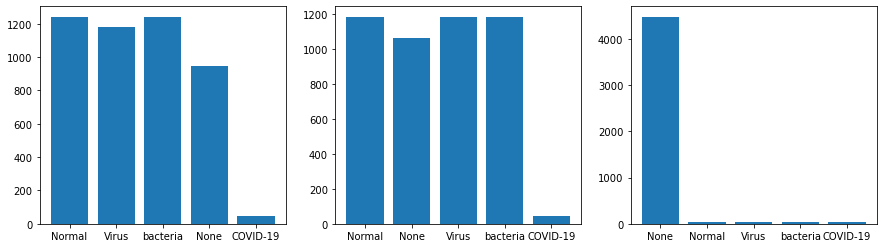

In [8]:
train_counter2 = Counter(final_data.loc[final_data['Final_split']=='TRAIN']['Label_Final2'])
train_counter3 = Counter(final_data.loc[final_data['Final_split']=='TRAIN']['Label_Final3'])
train_counter4 = Counter(final_data.loc[final_data['Final_split']=='TRAIN']['Label_Final4'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4)) #Print histograms of class frequencies.
axes[0].bar(train_counter2.keys(), train_counter2.values())
axes[1].bar(train_counter3.keys(), train_counter3.values())
axes[2].bar(train_counter4.keys(), train_counter4.values())
#We have gradually decreased the class imbalance by down-sampling the training data, finally we have equal number of random observations for all classes. 
plt.show()

In [9]:
def balance(seq): #Calculate Shannon Entropy for original and under sampled training sets
    from collections import Counter
    from numpy import log

    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)

    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) 
    return H/log(k)

In [10]:
#0.794 is quite low
balance(final_data.Label_Final[final_data['Final_split']=='TRAIN'])

0.7940739321167704

In [11]:
#Second level undersamplng increased Shonnan Entropy a lot.
balance(final_data.Label_Final3[(final_data['Label_Final3']!="None") & (final_data['Final_split']=='TRAIN')])

0.8317254349956127

In [12]:
#There is no imbalance in the third level undersampled data.
balance(final_data.Label_Final4[(final_data['Label_Final4']!="None") & (final_data['Final_split']=='TRAIN')])

1.0

In [13]:
#You may skip this step
final_data.to_csv('data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', encoding = 'ISO-8859-1') # Write dataset labels and train/test split to a new csv.

In [53]:
class CoronaDataset(Dataset): #Create a dataset class 
    """Price dataset."""

    def __init__(self, csv_file, root_dir, mode, stage=None, transform=None):

        self.image_inf = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.mode = mode
        self.stage = stage
        self.transform = transform
        self.label_dict={"Normal" : 0, "Virus" : 1, "bacteria" : 2, "COVID-19" : 3}

    def __len__(self):
        if self.mode=='test':
            image_inf = self.image_inf.loc[self.image_inf['Final_split']=='TEST']
            length=len(image_inf)
        elif self.mode=='eval':
            image_inf = self.image_inf.loc[self.image_inf['Final_split']=='EVAL']
            length=len(image_inf)
        else:
            if self.stage==3:
                image_inf = self.image_inf.loc[self.image_inf['Label_Final2']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                length=len(image_inf)
            elif self.stage==2:
                image_inf = self.image_inf.loc[self.image_inf['Label_Final3']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                length=len(image_inf)  
            elif self.stage==1:
                image_inf = self.image_inf.loc[self.image_inf['Label_Final4']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                length=len(image_inf)    
            else:    
                image_inf = self.image_inf.loc[self.image_inf['Final_split']=='TRAIN']
                length=len(image_inf)

        return length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.mode=='test': #Create test set
            image_inf = self.image_inf.loc[self.image_inf['Final_split']=='TEST']
            img_name = os.path.join(self.root_dir,
                                image_inf.iloc[idx, 1])# Read the ID's of images. 
            img_label=image_inf.iloc[idx, 2]                    
        elif self.mode=='eval': #Create validation set
            image_inf = self.image_inf.loc[self.image_inf['Final_split']=='EVAL']
            img_name = os.path.join(self.root_dir,
                                image_inf.iloc[idx, 1])# Read the ID's of images.    
            img_label=image_inf.iloc[idx, 2]                                
        else:#Create training set
            if self.stage==3: #Third-Phase Data
                image_inf = self.image_inf.loc[self.image_inf['Label_Final2']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                img_name = os.path.join(self.root_dir,
                                    image_inf.iloc[idx, 1])# Read the ID's of images.  
                img_label=image_inf.iloc[idx, 2]
            elif self.stage==2:#Second-Phase Data
                image_inf = self.image_inf.loc[self.image_inf['Label_Final3']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                img_name = os.path.join(self.root_dir,
                                    image_inf.iloc[idx, 1])# Read the ID's of images.  
                img_label=image_inf.iloc[idx, 2]    
            elif self.stage==1:#First-Phase Data
                image_inf = self.image_inf.loc[self.image_inf['Label_Final4']!='None']
                image_inf = image_inf.loc[image_inf['Final_split']=='TRAIN']
                img_name = os.path.join(self.root_dir,
                                    image_inf.iloc[idx, 1])# Read the ID's of images.  
                img_label=image_inf.iloc[idx, 2]     
            else: # This one gives the train data and labels without over or under sampling  
                image_inf = self.image_inf.loc[self.image_inf['Final_split']=='TRAIN']
                img_name = os.path.join(self.root_dir,
                                    image_inf.iloc[idx, 1])# Read the ID's of images.  
                img_label=image_inf.iloc[idx, 2]
                      
                                                                                
                     
        image = Image.open(img_name) # Read the image with the current ID.
        image = image.convert("RGB")
        sample = image
        
        label = torch.tensor(self.label_dict[img_label])

        if self.transform:
            sample = self.transform(sample) # Transform the image to tensor  

        return sample, label

In [ ]:
transform = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])#(0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ImageNet
        
test_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='test',
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) # Test Data set 
eval_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='eval',
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) # Validation Data set     

test_loader = DataLoader(test_data, batch_size=32, 
                        shuffle=True, num_workers=0) 
eval_loader = DataLoader(eval_data, batch_size=32, 
                        shuffle=True, num_workers=0) 
# Test and validation sets will be the same in all experiments, we just change training sets accordingly.
def accuracy(out, true_label):#Define accuracy function.
    values, indices = torch.max(out, 1)
    correct = (indices == true_label).float().sum()
    acc = correct/out.shape[0]
    return acc

<a id=’b’></a>
## 2. Base Model Training

We have trained the base model with original training data as a benchmark for our alternatives.

In [18]:
train_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train',
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) # Original train set

train_loader = DataLoader(train_data, batch_size=32, 
                        shuffle=True, num_workers=0)                                                                                 

In [86]:
class ConvClassifierModel(nn.Module):
    def __init__(self):
        super(ConvClassifierModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn2d64 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn2d32 = nn.BatchNorm2d(32, affine=False)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn2d16 = nn.BatchNorm2d(16, affine=False)
        self.fc1 = nn.Linear(8*8*16, 16*16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(16*16, 4)
        
        self.maxpool4 = nn.MaxPool2d(4, 4) 
        self.maxpool2 = nn.MaxPool2d(2, 2) 
        
        self.initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn2d64(x)
        x = self.relu(x)
        x = self.maxpool4(x) 
        x = self.conv2(x)
        x = self.bn2d32(x)
        x = self.relu(x)
        x = self.maxpool2(x) 
        x = self.conv3(x)
        x = self.bn2d16(x)
        x = self.relu(x)
        x = self.maxpool2(x) 
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc2(x)
        return out
    #Weight initialization for convolutional and linear layers with Xavier uniform distribution.
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0) 

            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

base_model = ConvClassifierModel()

In [24]:
#Training parameters 
base_model = ConvClassifierModel()
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 

optimizer = optim.Adam(params=base_model.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) #Use this the decrease LR at each epoch.

In [25]:
#Training loop which will be used for all models.
base_model.train()
if use_gpu:
    base_model.cuda()
    criteria.cuda()


losses_iter_train = []
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []

for epoch in range(n_epochs):
    for data in train_loader:
        optimizer.zero_grad() 

        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = base_model(img) 
        loss = criteria(outputs, label) 
        loss.backward() 
        optimizer.step() 

        losses_iter_train.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label) 
        accuracy_iter_train.append(acc.cpu().detach().numpy()) 
    if epoch % 1 == 0: 
        with torch.no_grad():
            base_model.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = base_model(img)
                val_loss = criteria(output, label)
                losses_iter_val.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step() 
    base_model.train()
    losses_epoch_train.append(np.mean(losses_iter_train)) 
    accuracy_epoch_train.append(np.mean(accuracy_iter_train)) 
    losses_epoch_val.append(np.mean(losses_iter_val)) 
    accuracy_epoch_val.append(np.mean(accuracy_iter_val)) 

    if accuracy_epoch_val[-1] == max(accuracy_epoch_val): 
        torch.save(base_model.state_dict(),'./best_base_model.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train[epoch], accuracy_epoch_train[epoch],losses_epoch_val[-1],accuracy_epoch_val[-1]))

torch.save(base_model.state_dict(),'./last_base_model.pth')  

Epoch: 0 	Training Loss: 0.958381 	Training Accuracy: 0.683064 	Validation Loss: 0.622772 	Validation Accuracy: 0.760938
Epoch: 1 	Training Loss: 0.774826 	Training Accuracy: 0.716327 	Validation Loss: 0.608500 	Validation Accuracy: 0.751562
Epoch: 2 	Training Loss: 0.702336 	Training Accuracy: 0.735024 	Validation Loss: 0.594578 	Validation Accuracy: 0.753646
Epoch: 3 	Training Loss: 0.659935 	Training Accuracy: 0.745364 	Validation Loss: 0.638829 	Validation Accuracy: 0.743750
Epoch: 4 	Training Loss: 0.633577 	Training Accuracy: 0.751350 	Validation Loss: 0.617931 	Validation Accuracy: 0.749062
Epoch: 5 	Training Loss: 0.610614 	Training Accuracy: 0.758464 	Validation Loss: 0.619628 	Validation Accuracy: 0.745833
Epoch: 6 	Training Loss: 0.593163 	Training Accuracy: 0.764382 	Validation Loss: 0.616239 	Validation Accuracy: 0.747768
Epoch: 7 	Training Loss: 0.579308 	Training Accuracy: 0.768502 	Validation Loss: 0.603661 	Validation Accuracy: 0.752539
Epoch: 8 	Training Loss: 0.56612

In [28]:
#Test loop which will be used for all models
losses_iter_test = []
losses_epoch_test = []
accuracy_iter_test = []
accuracy_epoch_test = []
predictions = []
labels = []

base_model.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = base_model(img)
        test_loss = criteria(output, label)
        losses_iter_test.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions.append(indices.cpu().numpy())
        labels.append(label.cpu().numpy())

    losses_epoch_test.append(np.mean(losses_iter_test)) 
    accuracy_epoch_test.append(np.mean(accuracy_iter_test))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('base_model Test',losses_epoch_test[-1],accuracy_epoch_test[-1]))

Test: base_model Test 	Test Loss: 0.808417 	Test Accuracy: 0.817187


In [30]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support #Import to calculate classification metrics

predictions=np.concatenate( predictions, axis=0 )
labels=np.concatenate( labels, axis=0 ) 
cm = confusion_matrix(labels, predictions) #Create a confusion matrix of GT labels and predictions
print(cm)

[[160   3   4   0]
 [  4  93  59   2]
 [  7  36 250   0]
 [  1   1   0   4]]


In [43]:
precision_recall_fscore_support(labels, predictions,average='weighted')#Calculate classification metrics

(0.8074608963497636, 0.8125, 0.8082996532583999, None)

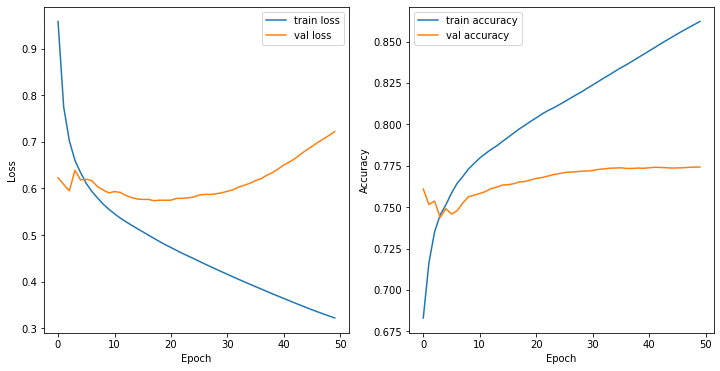

In [52]:
#Plot training and validation losses and accuracies.
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train, label='train loss')
plt.plot(losses_epoch_val, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train, label='train accuracy')
plt.plot(accuracy_epoch_val, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a id=’c’></a>
## 3. Training with Oversampled Data

At first we decided to work on oversampling techniques, however we have changed to multi-phase training with undersampling after searching the methods of fighting with class imbalance problem. But we still wanted to keep this first attempt of oversampling with data replication as a benchmark for our proposed model.

In [54]:
# Create training data for oversampled training
train_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data_oversample.csv', mode='train',
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) 

train_loader = DataLoader(train_data, batch_size=32, 
                        shuffle=True, num_workers=0)     

In [60]:
#Training parameters 
base_model_oversample = ConvClassifierModel()
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 

optimizer = optim.Adam(params=base_model_oversample.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) 

In [61]:
base_model_oversample.train()
if use_gpu:
    base_model_oversample.cuda()
    criteria.cuda()

losses_iter_train = []
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad() 
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = base_model_oversample(img) 
        loss = criteria(outputs, label) 
        loss.backward() 
        optimizer.step() 

        losses_iter_train.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label)
        accuracy_iter_train.append(acc.cpu().detach().numpy())
    if epoch % 1 == 0:
        with torch.no_grad():
            base_model_oversample.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = base_model_oversample(img)
                val_loss = criteria(output, label)
                losses_iter_val.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step() 
    base_model_oversample.train()
    losses_epoch_train.append(np.mean(losses_iter_train)) 
    accuracy_epoch_train.append(np.mean(accuracy_iter_train))
    losses_epoch_val.append(np.mean(losses_iter_val)) 
    accuracy_epoch_val.append(np.mean(accuracy_iter_val))

    if accuracy_epoch_val[-1] == max(accuracy_epoch_val): 
        torch.save(base_model_oversample.state_dict(),'./best_base_model_oversample.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train[epoch], accuracy_epoch_train[epoch],losses_epoch_val[-1],accuracy_epoch_val[-1]))

torch.save(base_model_oversample.state_dict(),'./last_base_model_oversample.pth') 

Epoch: 0 	Training Loss: 0.801696 	Training Accuracy: 0.707761 	Validation Loss: 0.649130 	Validation Accuracy: 0.737500
Epoch: 1 	Training Loss: 0.643106 	Training Accuracy: 0.756903 	Validation Loss: 0.620076 	Validation Accuracy: 0.744531
Epoch: 2 	Training Loss: 0.581491 	Training Accuracy: 0.774199 	Validation Loss: 0.595473 	Validation Accuracy: 0.754167
Epoch: 3 	Training Loss: 0.542434 	Training Accuracy: 0.786538 	Validation Loss: 0.575842 	Validation Accuracy: 0.758203
Epoch: 4 	Training Loss: 0.515543 	Training Accuracy: 0.793468 	Validation Loss: 0.557231 	Validation Accuracy: 0.764063
Epoch: 5 	Training Loss: 0.497463 	Training Accuracy: 0.799456 	Validation Loss: 0.557638 	Validation Accuracy: 0.763802
Epoch: 6 	Training Loss: 0.484281 	Training Accuracy: 0.803341 	Validation Loss: 0.550911 	Validation Accuracy: 0.765625
Epoch: 7 	Training Loss: 0.470260 	Training Accuracy: 0.808079 	Validation Loss: 0.550372 	Validation Accuracy: 0.766016
Epoch: 8 	Training Loss: 0.46008

In [66]:
losses_iter_test = []
losses_epoch_test = []
accuracy_iter_test = []
accuracy_epoch_test = []
predictions = []
labels = []

base_model_oversample.eval()

with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = base_model_oversample(img)
        test_loss = criteria(output, label)
        losses_iter_test.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions.append(indices.cpu().numpy())
        labels.append(label.cpu().numpy())

    losses_epoch_test.append(np.mean(losses_iter_test)) 
    accuracy_epoch_test.append(np.mean(accuracy_iter_test))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('base_model_oversample Test',losses_epoch_test[-1],accuracy_epoch_test[-1]))

Test: base_model_oversample Test 	Test Loss: 0.795611 	Test Accuracy: 0.829687


In [67]:
predictions=np.concatenate( predictions, axis=0 )
labels=np.concatenate( labels, axis=0 )
cm = confusion_matrix(labels, predictions)

In [68]:
print(cm)

[[161   4   2   0]
 [  3 102  51   2]
 [  1  44 248   0]
 [  0   1   0   5]]


In [69]:
precision_recall_fscore_support(labels, predictions,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.825920423288743, 0.8269230769230769, 0.8262113403926924, None)

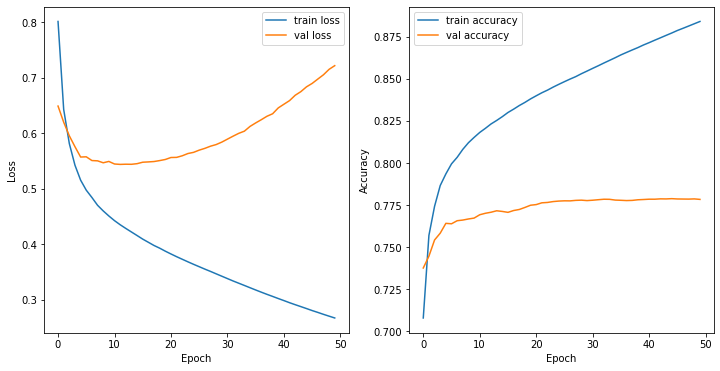

In [70]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train, label='train loss')
plt.plot(losses_epoch_val, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train, label='train accuracy')
plt.plot(accuracy_epoch_val, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a id=’d’></a>
## 4. Two-Phase Training with Undersampling

After some research on techniques to fight with class imbalance problem, we have found and interesting idea of two-phase training with random undersampling proposed in Lee et al. (2016). They basically split the training process into two parts. At first, they train a model with a RUS balanced data, and in the second phase they transfer the trained model from the first phase and finetune its classifier weights with the original distribution of the data to retain all the information on the original set.

In [105]:
#Create training data for the first phase of two-phase training method.
train_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train', stage=1,
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) 

train_loader = DataLoader(train_data, batch_size=32, 
                        shuffle=True, num_workers=0)     

In [106]:
#Training parameters 
twophase_model_first = ConvClassifierModel()
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 

optimizer = optim.Adam(params=twophase_model_first.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) 

In [107]:
twophase_model_first.train()
if use_gpu:
    twophase_model_first.cuda()
    criteria.cuda()

losses_iter_train = []
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad() 
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = twophase_model_first(img) 
        loss = criteria(outputs, label) 
        loss.backward() 
        optimizer.step() 

        losses_iter_train.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label) 
        accuracy_iter_train.append(acc.cpu().detach().numpy()) 
    if epoch % 1 == 0: 
        with torch.no_grad():
            twophase_model_first.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = twophase_model_first(img)
                val_loss = criteria(output, label)
                losses_iter_val.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step()      
    twophase_model_first.train()
    losses_epoch_train.append(np.mean(losses_iter_train)) 
    accuracy_epoch_train.append(np.mean(accuracy_iter_train)) 
    losses_epoch_val.append(np.mean(losses_iter_val)) 
    accuracy_epoch_val.append(np.mean(accuracy_iter_val))

    if accuracy_epoch_val[-1] == max(accuracy_epoch_val): 
        torch.save(twophase_model_first.state_dict(),'./best_twophase_model_first.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train[epoch], accuracy_epoch_train[epoch],losses_epoch_val[-1],accuracy_epoch_val[-1]))  

torch.save(twophase_model_first.state_dict(),'./last_twophase_model_first.pth')  

Epoch: 0 	Training Loss: 3.266681 	Training Accuracy: 0.368056 	Validation Loss: 1.913439 	Validation Accuracy: 0.567187
Epoch: 1 	Training Loss: 2.436039 	Training Accuracy: 0.440104 	Validation Loss: 1.806327 	Validation Accuracy: 0.459375
Epoch: 2 	Training Loss: 2.024680 	Training Accuracy: 0.498843 	Validation Loss: 1.523729 	Validation Accuracy: 0.514583
Epoch: 3 	Training Loss: 1.735450 	Training Accuracy: 0.528212 	Validation Loss: 1.374260 	Validation Accuracy: 0.545313
Epoch: 4 	Training Loss: 1.524828 	Training Accuracy: 0.562153 	Validation Loss: 1.297523 	Validation Accuracy: 0.549062
Epoch: 5 	Training Loss: 1.374715 	Training Accuracy: 0.590278 	Validation Loss: 1.222925 	Validation Accuracy: 0.565625
Epoch: 6 	Training Loss: 1.258096 	Training Accuracy: 0.622024 	Validation Loss: 1.174303 	Validation Accuracy: 0.569866
Epoch: 7 	Training Loss: 1.169233 	Training Accuracy: 0.639323 	Validation Loss: 1.117492 	Validation Accuracy: 0.586328
Epoch: 8 	Training Loss: 1.09162

In [108]:
losses_iter_test = []
losses_epoch_test = []
accuracy_iter_test = []
accuracy_epoch_test = []
predictions = []
labels = []

twophase_model_first.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = twophase_model_first(img)
        test_loss = criteria(output, label)
        losses_iter_test.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions.append(indices.cpu().numpy())
        labels.append(label.cpu().numpy())

    losses_epoch_test.append(np.mean(losses_iter_test)) 
    accuracy_epoch_test.append(np.mean(accuracy_iter_test))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('twophase_model_first Test',losses_epoch_test[-1],accuracy_epoch_test[-1]))

Test: twophase_model_first Test 	Test Loss: 0.856312 	Test Accuracy: 0.689062


In [109]:
predictions=np.concatenate( predictions, axis=0 )
labels=np.concatenate( labels, axis=0 )
cm = confusion_matrix(labels, predictions)
print(cm)

[[146  12   5   4]
 [  7 114  32   5]
 [ 18 107 164   4]
 [  0   0   0   6]]


In [110]:
precision_recall_fscore_support(labels, predictions,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.7385399516197132, 0.6891025641025641, 0.6952366855736147, None)

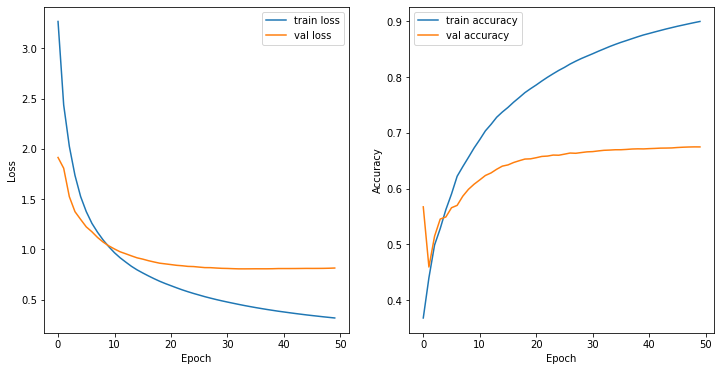

In [111]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train, label='train loss')
plt.plot(losses_epoch_val, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train, label='train accuracy')
plt.plot(accuracy_epoch_val, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [112]:
#Transfer the model with best accuracy from the first phase to fine-tune the dense layers with the original distribution of the data
twophase_model_second = ConvClassifierModel()
twophase_model_second.load_state_dict(torch.load('./models/best_twophase_model_first.pth'))
print(twophase_model_second)

ConvClassifierModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [113]:
#Freeze all layer except the dense layers.
count=0
for layer in twophase_model_second.children():
    count = count + 1
    if  count < 7:
        for param in layer.parameters():
                param.requires_grad = False
    else:           
        for param in layer.parameters():
                param.requires_grad = True 
    

#Check the trainable and total number of parameters.
total_params = sum(p.numel() for p in twophase_model_second.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in twophase_model_second.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

288,308 total parameters.
263,428 training parameters.


In [114]:
#Re-assign the dense layer for training
twophase_model_second.fc1=nn.Linear(8*8*16, 16*16)
twophase_model_second.fc2=nn.Linear(16*16, 4)

In [115]:
#Create training data for the second phase of two-phase training method.
train_data = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train', 
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) # Data set for Black&White Line Images

train_loader = DataLoader(train_data, batch_size=32, 
                        shuffle=True, num_workers=0)     

In [116]:
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 
###
optimizer = optim.Adam(params=twophase_model_second.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) 

In [117]:
twophase_model_second.train()
if use_gpu:
    twophase_model_second.cuda()
    criteria.cuda()


losses_iter_train = []
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad() 
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = twophase_model_second(img) 
        loss = criteria(outputs, label) 
        loss.backward() 
        optimizer.step() 

        losses_iter_train.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label) 
        accuracy_iter_train.append(acc.cpu().detach().numpy())
    if epoch % 1 == 0: 
        with torch.no_grad():
            twophase_model_second.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = twophase_model_second(img)
                val_loss = criteria(output, label)
                losses_iter_val.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val.append(val_acc.cpu().detach().numpy())
  
    lr_scheduler.step()       
    twophase_model_second.train()
    losses_epoch_train.append(np.mean(losses_iter_train)) 
    accuracy_epoch_train.append(np.mean(accuracy_iter_train)) 
    losses_epoch_val.append(np.mean(losses_iter_val)) 
    accuracy_epoch_val.append(np.mean(accuracy_iter_val))

    if accuracy_epoch_val[-1] == max(accuracy_epoch_val): 
        torch.save(twophase_model_second.state_dict(),'./best_twophase_model_second.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train[epoch], accuracy_epoch_train[epoch],losses_epoch_val[-1],accuracy_epoch_val[-1])) 

torch.save(twophase_model_second.state_dict(),'./last_twophase_model_second.pth')   

Epoch: 0 	Training Loss: 0.683337 	Training Accuracy: 0.716454 	Validation Loss: 0.525852 	Validation Accuracy: 0.782812
Epoch: 1 	Training Loss: 0.613283 	Training Accuracy: 0.743258 	Validation Loss: 0.523305 	Validation Accuracy: 0.781250
Epoch: 2 	Training Loss: 0.581473 	Training Accuracy: 0.756039 	Validation Loss: 0.524335 	Validation Accuracy: 0.779688
Epoch: 3 	Training Loss: 0.560215 	Training Accuracy: 0.764200 	Validation Loss: 0.529167 	Validation Accuracy: 0.776172
Epoch: 4 	Training Loss: 0.547801 	Training Accuracy: 0.768073 	Validation Loss: 0.528991 	Validation Accuracy: 0.775000
Epoch: 5 	Training Loss: 0.537292 	Training Accuracy: 0.773029 	Validation Loss: 0.525216 	Validation Accuracy: 0.776302
Epoch: 6 	Training Loss: 0.528137 	Training Accuracy: 0.776808 	Validation Loss: 0.521083 	Validation Accuracy: 0.778571
Epoch: 7 	Training Loss: 0.521649 	Training Accuracy: 0.779752 	Validation Loss: 0.518238 	Validation Accuracy: 0.780078
Epoch: 8 	Training Loss: 0.51318

In [124]:
losses_iter_test = []
losses_epoch_test = []
accuracy_iter_test = []
accuracy_epoch_test = []
predictions = []
labels = []

twophase_model_second.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = twophase_model_second(img)
        test_loss = criteria(output, label)
        losses_iter_test.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions.append(indices.cpu().numpy())
        labels.append(label.cpu().numpy())

    losses_epoch_test.append(np.mean(losses_iter_test)) 
    accuracy_epoch_test.append(np.mean(accuracy_iter_test))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('twophase_model_second Test',losses_epoch_test[-1],accuracy_epoch_test[-1]))

Test: twophase_model_second Test 	Test Loss: 0.629460 	Test Accuracy: 0.807813


In [125]:
predictions=np.concatenate( predictions, axis=0 )
labels=np.concatenate( labels, axis=0 )
cm = confusion_matrix(labels, predictions)
print(cm)

[[157   7   3   0]
 [  4  96  56   2]
 [  4  47 242   0]
 [  0   0   0   6]]


In [126]:
precision_recall_fscore_support(labels, predictions,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.8014281035501966, 0.8028846153846154, 0.8017994992141579, None)

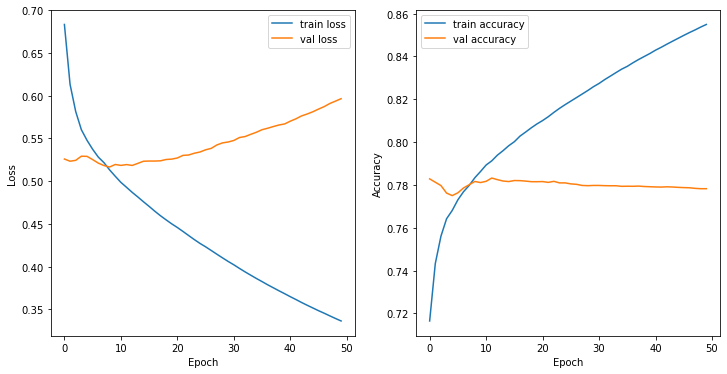

In [127]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train, label='train loss')
plt.plot(losses_epoch_val, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train, label='train accuracy')
plt.plot(accuracy_epoch_val, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a id=’e’></a>
## 5. Multi-Phase Training with Undersampling

After application of two-phase training approach, we saw that it increase the performance on minority class very well. So we designed an innovation on it to perform better. The basic idea of our proposed multi-phase training approach is that we want to train the model with different RUS data level gradullay to reach a better performance. A more detailed explanation is made on our report.

In [143]:
#Create training data for the second phase of multi-phase training method.
train_data_2 = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train', stage=2,
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) 
train_loader_2 = DataLoader(train_data_2, batch_size=32, 
                        shuffle=True, num_workers=0) #                                     

In [144]:
#Here we directly transfer the best model from the first phase of two-phase training and skip training the first phase of multi-phase approach because it is exactly the same procedure. 
model_stage2 = ConvClassifierModel()
model_stage2.load_state_dict(torch.load('./models/best_twophase_model_first.pth'))
print(model_stage2)

ConvClassifierModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [145]:
#Here we freeze only the first convolutional block, and train the rest of the model with next level of RUS data.
count=0
for layer in model_stage2.children():
    count = count + 1
    if  count < 3:
        for param in layer.parameters():
                param.requires_grad = False
    else:           
        for param in layer.parameters():
                param.requires_grad = True 
    
total_params = sum(p.numel() for p in model_stage2.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_stage2.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

288,308 total parameters.
286,516 training parameters.


In [146]:
#Re-assign the layers which will be trained in this phase.
model_stage2.conv2=nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
model_stage2.bn2d32=nn.BatchNorm2d(32, affine=False)
model_stage2.conv3=nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
model_stage2.bn2d16=nn.BatchNorm2d(16, affine=False)
model_stage2.fc1=nn.Linear(8*8*16, 16*16)
model_stage2.fc2=nn.Linear(16*16, 4)

In [147]:
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 
###
optimizer = optim.Adam(params=model_stage2.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) 

In [148]:
model_stage2.train()
if use_gpu:
    model_stage2.cuda()
    criteria.cuda()

losses_iter_train_stage2 = []
losses_epoch_train_stage2 = []
accuracy_iter_train_stage2 = []
accuracy_epoch_train_stage2 = []

losses_iter_val_stage2 = []
losses_epoch_val_stage2 = []
accuracy_iter_val_stage2 = []
accuracy_epoch_val_stage2 = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad()
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = model_stage2(img)
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        losses_iter_train_stage2.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label)
        accuracy_iter_train_stage2.append(acc.cpu().detach().numpy())
    if epoch % 1 == 0:
        with torch.no_grad():
            model_stage2.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = model_stage2(img)
                val_loss = criteria(output, label)
                losses_iter_val_stage2.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val_stage2.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step()        
    model_stage2.train()
    losses_epoch_train_stage2.append(np.mean(losses_iter_train_stage2)) 
    accuracy_epoch_train_stage2.append(np.mean(accuracy_iter_train_stage2))
    losses_epoch_val_stage2.append(np.mean(losses_iter_val_stage2)) 
    accuracy_epoch_val_stage2.append(np.mean(accuracy_iter_val_stage2)) 

    if accuracy_epoch_val_stage2[-1] == max(accuracy_epoch_val_stage2):
        torch.save(model_stage2.state_dict(),'best_model_stage2.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train_stage2[epoch], accuracy_epoch_train_stage2[epoch],losses_epoch_val_stage2[-1],accuracy_epoch_val_stage2[-1]))

torch.save(model_stage2.state_dict(),'last_model_stage2.pth')

Epoch: 0 	Training Loss: 0.706086 	Training Accuracy: 0.709488 	Validation Loss: 0.576384 	Validation Accuracy: 0.760938
Epoch: 1 	Training Loss: 0.631470 	Training Accuracy: 0.739016 	Validation Loss: 0.559512 	Validation Accuracy: 0.765625
Epoch: 2 	Training Loss: 0.600639 	Training Accuracy: 0.754041 	Validation Loss: 0.551705 	Validation Accuracy: 0.770833
Epoch: 3 	Training Loss: 0.578446 	Training Accuracy: 0.762779 	Validation Loss: 0.543402 	Validation Accuracy: 0.774609
Epoch: 4 	Training Loss: 0.560296 	Training Accuracy: 0.770326 	Validation Loss: 0.536595 	Validation Accuracy: 0.775000
Epoch: 5 	Training Loss: 0.546540 	Training Accuracy: 0.775241 	Validation Loss: 0.531105 	Validation Accuracy: 0.777604
Epoch: 6 	Training Loss: 0.535741 	Training Accuracy: 0.780032 	Validation Loss: 0.532865 	Validation Accuracy: 0.778125
Epoch: 7 	Training Loss: 0.524960 	Training Accuracy: 0.784456 	Validation Loss: 0.527809 	Validation Accuracy: 0.778516
Epoch: 8 	Training Loss: 0.51671

In [149]:
losses_iter_test_stage2 = []
losses_epoch_test_stage2 = []
accuracy_iter_test_stage2 = []
accuracy_epoch_test_stage2 = []
predictions_stage2 = []
labels_stage2 = []

model_stage2.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = model_stage2(img)
        test_loss = criteria(output, label)
        losses_iter_test_stage2.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test_stage2.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions_stage2.append(indices.cpu().numpy())
        labels_stage2.append(label.cpu().numpy())

    losses_epoch_test_stage2.append(np.mean(losses_iter_test_stage2)) 
    accuracy_epoch_test_stage2.append(np.mean(accuracy_iter_test_stage2))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('Basemodel_stage2 Test',losses_epoch_test_stage2[-1],accuracy_epoch_test_stage2[-1]))

Test: Basemodel_stage2 Test 	Test Loss: 0.977498 	Test Accuracy: 0.798437


In [150]:
from sklearn.metrics import confusion_matrix
predictions_stage2=np.concatenate( predictions_stage2, axis=0 )
labels_stage2=np.concatenate( labels_stage2, axis=0 )
cm = confusion_matrix(labels_stage2, predictions_stage2)
print(cm)

[[157   4   6   0]
 [  4  99  53   2]
 [  4  52 237   0]
 [  0   0   1   5]]


In [151]:
precision_recall_fscore_support(labels_stage2, predictions_stage2,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.7979374269696851, 0.7980769230769231, 0.7979219068526205, None)

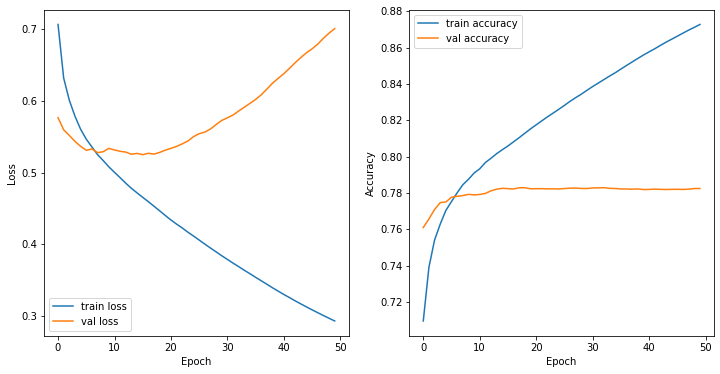

In [152]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train_stage2, label='train loss')
plt.plot(losses_epoch_val_stage2, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train_stage2, label='train accuracy')
plt.plot(accuracy_epoch_val_stage2, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [153]:
#Create training data for the third phase of multi-phase training method.
train_data_3 = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train', stage=3,
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) # Data set for Black&White Line Images
train_loader_3 = DataLoader(train_data_3, batch_size=32, 
                        shuffle=True, num_workers=0) #      

In [154]:
#Transfer the best accuracy model from second phase of multi-phase training.
model_stage3 = ConvClassifierModel()
model_stage3.load_state_dict(torch.load('./models/best_model_stage2.pth'))
print(model_stage3)

ConvClassifierModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [155]:
#Here we freeze only the first two convolutional blocks, and train the rest of the model with next level of RUS data.
count=0
for layer in model_stage3.children():
    count = count + 1
    if  count < 5:
        for param in layer.parameters():
                param.requires_grad = False
    else:           
        for param in layer.parameters():
                param.requires_grad = True 
    
total_params = sum(p.numel() for p in model_stage3.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_stage3.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

288,308 total parameters.
268,052 training parameters.


In [156]:
#Re-assign the layers which will be trained in this phase.
model_stage3.conv3=nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
model_stage3.bn2d16=nn.BatchNorm2d(16, affine=False)
model_stage3.fc1=nn.Linear(8*8*16, 16*16)
model_stage3.fc2=nn.Linear(16*16, 4)

In [157]:
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 
###
optimizer = optim.Adam(params=model_stage3.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) 

In [158]:
model_stage3.train()
if use_gpu:
    model_stage3.cuda()
    criteria.cuda()

losses_iter_train_stage3 = []
losses_epoch_train_stage3 = []
accuracy_iter_train_stage3 = []
accuracy_epoch_train_stage3 = []

losses_iter_val_stage3 = []
losses_epoch_val_stage3 = []
accuracy_iter_val_stage3 = []
accuracy_epoch_val_stage3 = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad()
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = model_stage3(img)
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        losses_iter_train_stage3.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label)
        accuracy_iter_train_stage3.append(acc.cpu().detach().numpy())
    if epoch % 1 == 0:
        with torch.no_grad():
            model_stage3.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = model_stage3(img)
                val_loss = criteria(output, label)
                losses_iter_val_stage3.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val_stage3.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step()        
    model_stage3.train()
    losses_epoch_train_stage3.append(np.mean(losses_iter_train_stage3)) 
    accuracy_epoch_train_stage3.append(np.mean(accuracy_iter_train_stage3))
    losses_epoch_val_stage3.append(np.mean(losses_iter_val_stage3)) 
    accuracy_epoch_val_stage3.append(np.mean(accuracy_iter_val_stage3)) 

    if accuracy_epoch_val_stage3[-1] == max(accuracy_epoch_val_stage3):
        torch.save(model_stage3.state_dict(),'best_model_stage3.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train_stage3[epoch], accuracy_epoch_train_stage3[epoch],losses_epoch_val_stage3[-1],accuracy_epoch_val_stage3[-1]))

torch.save(model_stage3.state_dict(),'last_model_stage3.pth')

Epoch: 0 	Training Loss: 0.696914 	Training Accuracy: 0.721999 	Validation Loss: 0.529018 	Validation Accuracy: 0.776563
Epoch: 1 	Training Loss: 0.612251 	Training Accuracy: 0.749737 	Validation Loss: 0.535233 	Validation Accuracy: 0.775000
Epoch: 2 	Training Loss: 0.578154 	Training Accuracy: 0.763154 	Validation Loss: 0.531116 	Validation Accuracy: 0.779167
Epoch: 3 	Training Loss: 0.553485 	Training Accuracy: 0.772956 	Validation Loss: 0.533873 	Validation Accuracy: 0.778125
Epoch: 4 	Training Loss: 0.532803 	Training Accuracy: 0.780853 	Validation Loss: 0.544225 	Validation Accuracy: 0.779688
Epoch: 5 	Training Loss: 0.515161 	Training Accuracy: 0.787100 	Validation Loss: 0.537839 	Validation Accuracy: 0.779167
Epoch: 6 	Training Loss: 0.501880 	Training Accuracy: 0.791960 	Validation Loss: 0.537522 	Validation Accuracy: 0.781250
Epoch: 7 	Training Loss: 0.489572 	Training Accuracy: 0.795951 	Validation Loss: 0.536225 	Validation Accuracy: 0.781055
Epoch: 8 	Training Loss: 0.47872

In [159]:
losses_iter_test_stage3 = []
losses_epoch_test_stage3 = []
accuracy_iter_test_stage3 = []
accuracy_epoch_test_stage3 = []
predictions_stage3 = []
labels_stage3 = []

model_stage3.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = model_stage3(img)
        test_loss = criteria(output, label)
        losses_iter_test_stage3.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test_stage3.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions_stage3.append(indices.cpu().numpy())
        labels_stage3.append(label.cpu().numpy())

    losses_epoch_test_stage3.append(np.mean(losses_iter_test_stage3)) 
    accuracy_epoch_test_stage3.append(np.mean(accuracy_iter_test_stage3))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('Basemodel_stage3 Test',losses_epoch_test_stage3[-1],accuracy_epoch_test_stage3[-1]))

Test: Basemodel_stage3 Test 	Test Loss: 1.288297 	Test Accuracy: 0.815625


In [160]:
predictions_stage3=np.concatenate( predictions_stage3, axis=0 )
labels_stage3=np.concatenate( labels_stage3, axis=0 )
cm = confusion_matrix(labels_stage3, predictions_stage3)
print(cm)

[[156   5   6   0]
 [  4 105  47   2]
 [  3  49 241   0]
 [  0   0   0   6]]


In [161]:
precision_recall_fscore_support(labels_stage3, predictions_stage3,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.8154617237327704, 0.8141025641025641, 0.8145704707840951, None)

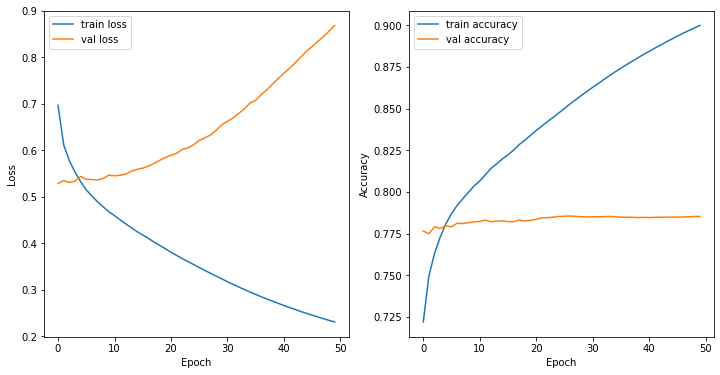

In [162]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train_stage3, label='train loss')
plt.plot(losses_epoch_val_stage3, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train_stage3, label='train accuracy')
plt.plot(accuracy_epoch_val_stage3, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [163]:
#Create training data for the fourth(last) phase of multi-phase training method.
train_data_4 = CoronaDataset(csv_file='./data/Coronahack-Chest-XRay-Dataset/alldata/Final_data.csv', mode='train', stage=4,
                                    root_dir='./data/Coronahack-Chest-XRay-Dataset/alldata',transform=transform) 
train_loader_4 = DataLoader(train_data_4, batch_size=32, 
                        shuffle=True, num_workers=0) #   

In [164]:
#Transfer the best accuracy model from second phase of multi-phase training.
model_stage4 = ConvClassifierModel()
model_stage4.load_state_dict(torch.load('./models/best_model_stage3.pth'))
print(model_stage4)

ConvClassifierModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [165]:
#Here we freeze all convolutional blocks, and train the rest of the model with original data.
count=0
for layer in model_stage4.children():
    count = count + 7
    if  count < 4:
        for param in layer.parameters():
                param.requires_grad = False
    else:           
        for param in layer.parameters():
                param.requires_grad = True 
    
total_params = sum(p.numel() for p in model_stage4.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_stage4.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

288,308 total parameters.
288,308 training parameters.


In [166]:
#Re-assign the layers which will be trained in this phase.
model_stage4.fc1=nn.Linear(8*8*16, 16*16)
model_stage4.fc2=nn.Linear(16*16, 4)

In [167]:
learning_rate = 3e-3
n_epochs = 50
use_gpu = True
decayRate = 0.96 
###
optimizer = optim.Adam(params=model_stage4.parameters(), lr=learning_rate) 
criteria = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [168]:
model_stage4.train()
if use_gpu:
    model_stage4.cuda()
    criteria.cuda()

losses_iter_train_stage4 = []
losses_epoch_train_stage4 = []
accuracy_iter_train_stage4 = []
accuracy_epoch_train_stage4 = []

losses_iter_val_stage4 = []
losses_epoch_val_stage4 = []
accuracy_iter_val_stage4 = []
accuracy_epoch_val_stage4 = []

for epoch in range(n_epochs):
    for data in train_loader:

        optimizer.zero_grad()
        
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
        outputs = model_stage4(img)
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        losses_iter_train_stage4.append(loss.cpu().detach().numpy()) 

        acc = accuracy(outputs, label)
        accuracy_iter_train_stage4.append(acc.cpu().detach().numpy())
    if epoch % 1 == 0:
        with torch.no_grad():
            model_stage4.eval()
            for data in eval_loader:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                pass
                output = model_stage4(img)
                val_loss = criteria(output, label)
                losses_iter_val_stage4.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy(output, label)
                accuracy_iter_val_stage4.append(val_acc.cpu().detach().numpy())

    lr_scheduler.step()        
    model_stage4.train()
    losses_epoch_train_stage4.append(np.mean(losses_iter_train_stage4)) 
    accuracy_epoch_train_stage4.append(np.mean(accuracy_iter_train_stage4))
    losses_epoch_val_stage4.append(np.mean(losses_iter_val_stage4)) 
    accuracy_epoch_val_stage4.append(np.mean(accuracy_iter_val_stage4)) 

    if accuracy_epoch_val_stage4[-1] == max(accuracy_epoch_val_stage4):
        torch.save(model_stage4.state_dict(),'best_model_stage4.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, losses_epoch_train_stage4[epoch], accuracy_epoch_train_stage4[epoch],losses_epoch_val_stage4[-1],accuracy_epoch_val_stage4[-1]))

torch.save(model_stage4.state_dict(),'last_model_stage4.pth')

Epoch: 0 	Training Loss: 0.625712 	Training Accuracy: 0.745447 	Validation Loss: 0.599287 	Validation Accuracy: 0.734375
Epoch: 1 	Training Loss: 0.569217 	Training Accuracy: 0.763845 	Validation Loss: 0.581208 	Validation Accuracy: 0.746875
Epoch: 2 	Training Loss: 0.534889 	Training Accuracy: 0.776930 	Validation Loss: 0.562850 	Validation Accuracy: 0.759896
Epoch: 3 	Training Loss: 0.515515 	Training Accuracy: 0.784495 	Validation Loss: 0.558495 	Validation Accuracy: 0.764453
Epoch: 4 	Training Loss: 0.499949 	Training Accuracy: 0.790294 	Validation Loss: 0.571115 	Validation Accuracy: 0.759063
Epoch: 5 	Training Loss: 0.489002 	Training Accuracy: 0.793972 	Validation Loss: 0.565317 	Validation Accuracy: 0.760677
Epoch: 6 	Training Loss: 0.478830 	Training Accuracy: 0.798735 	Validation Loss: 0.559348 	Validation Accuracy: 0.764732
Epoch: 7 	Training Loss: 0.467008 	Training Accuracy: 0.803362 	Validation Loss: 0.553766 	Validation Accuracy: 0.767773
Epoch: 8 	Training Loss: 0.45689

In [169]:
losses_iter_test_stage4 = []
losses_epoch_test_stage4 = []
accuracy_iter_test_stage4 = []
accuracy_epoch_test_stage4 = []
predictions_stage4 = []
labels_stage4 = []

model_stage4.eval()

with torch.no_grad(): 
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass    
        output = model_stage4(img)
        test_loss = criteria(output, label)
        losses_iter_test_stage4.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(output, label)
        accuracy_iter_test_stage4.append(test_acc.cpu().detach().numpy())
        values, indices = torch.max(output, 1)
        predictions_stage4.append(indices.cpu().numpy())
        labels_stage4.append(label.cpu().numpy())

    losses_epoch_test_stage4.append(np.mean(losses_iter_test_stage4)) 
    accuracy_epoch_test_stage4.append(np.mean(accuracy_iter_test_stage4))
    print('Test: {} \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format('Basemodel_stage4 Test',losses_epoch_test_stage4[-1],accuracy_epoch_test_stage4[-1]))

Test: Basemodel_stage4 Test 	Test Loss: 1.454347 	Test Accuracy: 0.814062


In [170]:
predictions_stage4=np.concatenate( predictions_stage4, axis=0 )
labels_stage4=np.concatenate( labels_stage4, axis=0 )
cm = confusion_matrix(labels_stage4, predictions_stage4)
print(cm)

[[159   3   5   0]
 [  8  88  61   1]
 [  5  34 254   0]
 [  0   0   0   6]]


In [171]:
precision_recall_fscore_support(labels_stage4, predictions_stage4,average='weighted')
#0.8074608963497636, 0.8125, 0.8082996532583999, None)

(0.8066049905762842, 0.8125, 0.8065179662443156, None)

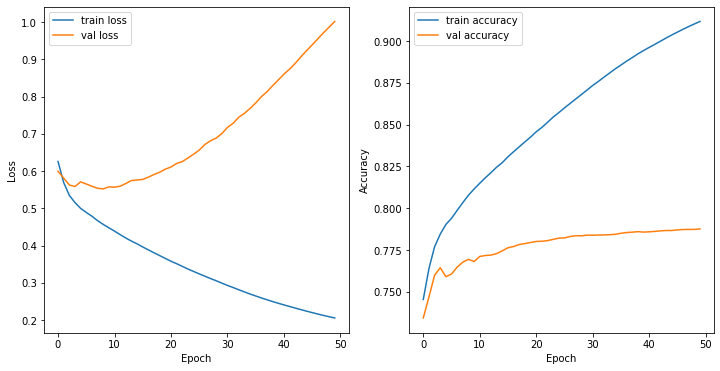

In [172]:
plt.subplot(1, 2, 1)
plt.plot(losses_epoch_train_stage4, label='train loss')
plt.plot(losses_epoch_val_stage4, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch_train_stage4, label='train accuracy')
plt.plot(accuracy_epoch_val_stage4, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()